## Figures  
Computations to produce figures in Elling et al., 2025  
See analysis_cmip6.ipynb for CMIP6 model projections figure

## Table of contents (skip to section)
[Figure 1. Malaria overview](#Figure-1.-Malaria-overview)  
[Figure 2. Malaria/SST relationship](#Figure-2.-Malaria/SST-relationship)   
[Figure 3. Atmospheric response to SST regions - 1](#Figure-3.-Atmospheric-response-to-SST-regions-(wind-and-geopotential))   
[Figure 4. Atmospheric response to SST regions - 2](#Figure-4.-Atmospheric-response-to-SST-regions-(vimdf,-precip,-and-soil-moisture))   
[Figure 5. Soil moisture vs. other predictors](#Figure-5.-Soil-moisture-vs.-other-predictors)   
[Figure 6. Relationship between soil moisture and malaria](#Figure-6.-Relationship-between-soil-moisture-and-malaria)  
[Supplementary/Extended data](#Supplementary/Extended-data)  

In [2]:
# cosmetic plotting bug fix: fix degrees label bug on map
def format_lon(x, pos=None):
    if x == 0:
        return "0"
    return f"{abs(int(x))}{'E' if x > 0 else 'W'}"

def format_lat(y, pos=None):
    if y == 0:
        return "0"
    return f"{abs(int(y))}{'N' if y > 0 else 'S'}"

In [3]:
data = load_data()

# all the variable names used below should be == the dictionary keys
for key, item in data.items():
    locals()[key] = item # set variable name to key name 

loaded 65 datasets


In [1]:
import analysis_tools as atools # novel functions
import format_data as fdata # novel functions

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cfgrib
import cmocean as cm
import cmcrameri.cm as cmc
import geopandas as gpd
import glob
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scienceplots
import statsmodels.api as sm
import warnings
import xarray as xr

from eofs.standard import Eof
from eofs.xarray import Eof as xEof
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter
from metpy.calc import wind_direction, wind_speed
from metpy.units import units
from rasterio.enums import Resampling
from scipy import signal, stats
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d
from scipy.signal import butter, filtfilt, freqz, lfilter
from scipy.stats import pearsonr, t, zscore
from shapely.affinity import rotate, translate
from shapely.geometry import Polygon, mapping
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

from load_preprocessed_data import load_data # novel import

mpl.rcParams['font.family'] = 'serif'
warnings.filterwarnings("ignore")

## Figure 1. Malaria overview

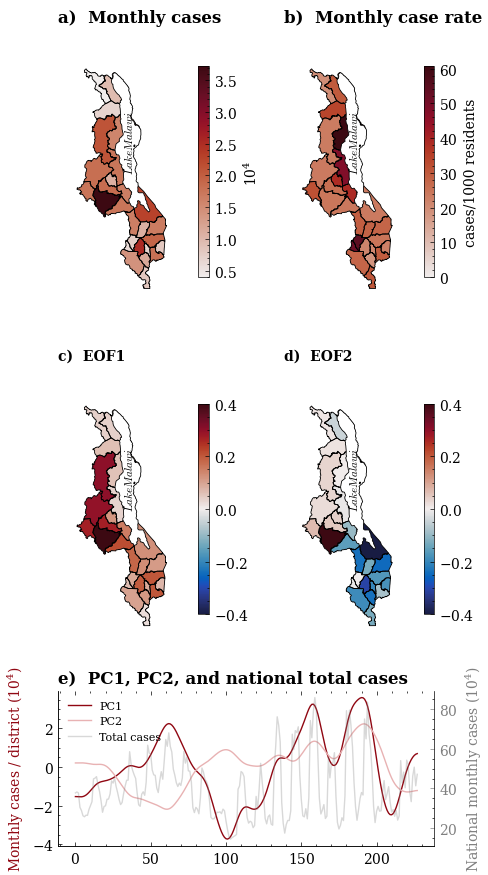

In [4]:
with plt.style.context('science'):
    plt.style.use(['no-latex'])

    fig = plt.figure(figsize=(4, 10))
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 0.5], hspace=0.1, wspace=0.5)

    # Panel a
    ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
    ax.set_extent([32, 37, -18, -8], crs=ccrs.PlateCarree())
    malavgscale = malavg.copy()
    malavgscale["CASES"] = malavgscale["CASES"]*1e-4
    malavg.plot(ax=ax, facecolor="None", edgecolor="black", linewidth=0.6, transform=ccrs.PlateCarree(), zorder=2)
    im0 = malavgscale.plot(column='CASES', cmap=cm.cm.amp, ax=ax, transform=ccrs.PlateCarree(), zorder=1)
    plt.sca(ax)
    plt.xlim(32, 37)
    plt.ylim(-18, -8)
    plt.gca().set_aspect('equal')
    ax.axis('off')
    fig.colorbar(im0.get_children()[1], ax=ax, orientation='vertical', fraction=0.07, shrink=0.99, pad=0.01, label=r'$\mathregular{10^4}$')
    lake_malawi.plot(ax=ax, color="white", alpha=1, zorder=12, edgecolor="black", linewidth=0.6)
    ax.annotate(text='$\it{Lake Malawi}$', xy=(34.53, -13), ha='center', zorder=13, color="black", fontsize=8, rotation=90)
    ax.set_title("a)  Monthly cases", fontsize=12, weight='bold', loc='left')
    
    # Panel b
    ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
    ax.set_extent([32, 37, -18, -8], crs=ccrs.PlateCarree())
    malavg.plot(ax=ax, facecolor="None", edgecolor="black", linewidth=0.6, transform=ccrs.PlateCarree(), zorder=2)
    im1 = malavg.plot(column='CASERATE1000', cmap=cm.cm.amp, ax=ax, vmin=0, transform=ccrs.PlateCarree())
    plt.sca(ax)
    plt.xlim(32, 37)
    plt.ylim(-18, -8)
    plt.gca().set_aspect('equal')
    ax.axis('off')
    fig.colorbar(im1.get_children()[1], ax=ax, orientation='vertical', fraction=0.07, shrink=0.99, pad=0.01, label="cases/1000 residents")
    lake_malawi.plot(ax=ax, color="white", alpha=1, zorder=12, edgecolor="black", linewidth=0.6)
    ax.annotate(text='$\it{Lake Malawi}$', xy=(34.53, -13), ha='center', zorder=13, color="black", fontsize=8, rotation=90)
    ax.set_title("b)  Monthly case rate", fontsize=12, weight='bold', loc='left')

    # Panel c
    ax = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
    ax.set_extent([32, 37, -18, -8], crs=ccrs.PlateCarree())
    malavg.plot(ax=ax, facecolor="None", edgecolor="black", linewidth=0.6, transform=ccrs.PlateCarree(), zorder=2)
    im2 = malavg.plot(column='EOF1', cmap=cm.cm.balance, vmin=-0.4, vmax=0.4, ax=ax, transform=ccrs.PlateCarree(), zorder=1)
    plt.sca(ax)
    plt.xlim(32, 37)
    plt.ylim(-18, -8)
    plt.gca().set_aspect('equal')
    ax.axis('off')
    fig.colorbar(im2.get_children()[1], ax=ax, orientation='vertical', fraction=0.07, shrink=0.99, pad=0.01)
    lake_malawi.plot(ax=ax, color="white", alpha=1, zorder=12, edgecolor="black", linewidth=0.6)
    ax.annotate(text='$\it{Lake Malawi}$', xy=(34.53, -13), ha='center', zorder=13, color="black", fontsize=8, rotation=90)
    ax.set_title("c)  EOF1", fontsize=12, font="serif", weight='bold', loc='left')

    # Panel d
    ax = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
    ax.set_extent([32, 37, -18, -8], crs=ccrs.PlateCarree())
    malavg.plot(ax=ax, facecolor="None", edgecolor="black", linewidth=0.6, transform=ccrs.PlateCarree(), zorder=2)
    im3 = malavg.plot(column='EOF2', cmap=cm.cm.balance, vmin=-0.4, vmax=0.4, ax=ax, transform=ccrs.PlateCarree(), zorder=1)
    plt.sca(ax)
    plt.xlim(32, 37)
    plt.ylim(-18, -8)
    plt.gca().set_aspect('equal')
    ax.axis('off')
    fig.colorbar(im3.get_children()[1], ax=ax, orientation='vertical', fraction=0.07, shrink=0.99, pad=0.01)
    lake_malawi.plot(ax=ax, color="white", alpha=1, zorder=12, edgecolor="black", linewidth=0.6)
    ax.annotate(text='$\it{Lake Malawi}$', xy=(34.53, -13), ha='center', zorder=13, color="black", fontsize=8, rotation=90)
    ax.set_title("d)  EOF2", fontsize=12, font="serif", weight='bold', loc='left')
    fig.subplots_adjust(left=0.01, right=0.95)
    
    # Panel e
    ax = fig.add_subplot(gs[2, :])
    ax_right = ax.twinx()
    
    pc1_line = ax.plot(cases_pivot.index, pc1/1e4, label='PC1', color='#900712', linewidth=1, zorder=2)
    pc2_line= ax.plot(cases_pivot.index, pc2/1e4, label='PC2', color='#E8B2B3', linewidth=1, zorder=2)
    
    nattot_line = ax_right.plot(cases_pivot.index, nattot/1e4, label='Total cases', color='grey', linestyle='-', linewidth=1, alpha=0.3, zorder=0)
    
    ax.set_ylabel('Monthly cases / district ($\mathregular{10^4}$)', fontsize=10, color='#900712')
    ax_right.set_ylabel('National monthly cases ($\mathregular{10^4}$)', fontsize=10, color='grey')
    
    ax.tick_params(axis='both', labelsize=10)
    ax_right.tick_params(axis='y', labelsize=10, colors='grey')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax_right.spines['top'].set_visible(False)
    
    handles = [pc1_line[0], pc2_line[0], nattot_line[0]]
    labels = [h.get_label() for h in handles]
    ax.legend(handles, labels, frameon=False, loc='upper left', fontsize=8)
    
    ax.set_title('e)  PC1, PC2, and national total cases', fontsize=12, weight='bold', loc='left')

    #plt.tight_layout()
    plt.subplots_adjust(bottom=0.05)
    plt.savefig("figures/manuscript/Figure1.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

## Figure 2. Malaria/SST relationship

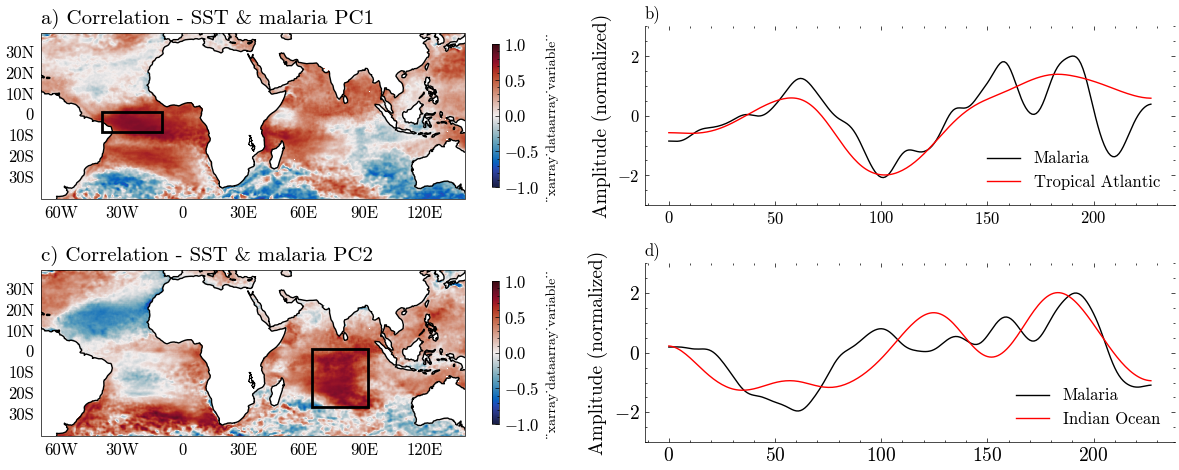

In [5]:
with plt.style.context('science'):
    plt.style.use(['no-latex'])
    africa_extent = [-70, 140, -40, 40]  # [min_lon, max_lon, min_lat, max_lat]
    
    fig = plt.figure(figsize=(12, 4.9))
    
    # Panel a - correlation_map_pc1
    ax1 = fig.add_subplot(2, 2, 1, projection=ccrs.PlateCarree())
    ax1.set_extent(africa_extent, crs=ccrs.PlateCarree())
    cm1 = correlation_map_pc1.plot(ax=ax1, cmap=cm.cm.balance, vmin=-1, vmax=1, transform=ccrs.PlateCarree(), 
                             cbar_kwargs={"shrink": 0.8})
    cm1.colorbar.ax.tick_params(labelsize=12)
    
    # get region box
    min_lon, max_lon = -40, -10
    min_lat, max_lat = -8, 2
    
    rect = Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                     linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
    ax1.add_patch(rect)
    
    ax1.coastlines()
    gl = ax1.gridlines(draw_labels=True, linewidth=0)
    gl.xformatter = FuncFormatter(format_lon)
    gl.yformatter = FuncFormatter(format_lat)
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}
    gl.right_labels = []  # Remove right labels
    gl.top_labels = []    # Remove top labels
    ax1.set_title('a) Correlation - SST & malaria PC1', fontsize=15, weight='bold', loc='left')
    malawi_shape.plot(ax=ax1, edgecolor="black", linewidth=0.5, color="None")


    # Panel b - PC1 and tropatl
    ax2 = fig.add_subplot(2, 2, 2)

    ax2.plot(cases_pivot.index, zscore(pc1), label='Malaria', color='black', linewidth=1, zorder=2)
    ax2.plot(cases_pivot.index, zscore(tropatl_weighted_smooth), label='Tropical Atlantic', color='red', linewidth=1, zorder=2)
    ax2.set_ylim(-3, 3)
    ax2.set_ylabel(r'Amplitude (normalized)', fontsize=14)
    ax2.tick_params(axis='both', labelsize=12)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.legend(frameon=False, fontsize=12, loc="lower right")
    ax2.set_title('b)', fontsize=12, weight='bold', loc='left')
    
    # Panel c - correlation_map_pc2
    ax3 = fig.add_subplot(2, 2, 3, projection=ccrs.PlateCarree())
    ax3.set_extent(africa_extent, crs=ccrs.PlateCarree())
    cm2 = correlation_map_pc2.plot(ax=ax3, cmap=cm.cm.balance, vmin=-1, vmax=1, transform=ccrs.PlateCarree(), 
                             cbar_kwargs={"shrink": 0.8})
    cm2.colorbar.ax.tick_params(labelsize=12)
    # get region box
    min_lon, max_lon = 64, 92
    min_lat, max_lat = -26, 2
    
    rect = Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                     linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
    ax3.add_patch(rect)
    
    ax3.coastlines()
    gl = ax3.gridlines(draw_labels=True, linewidth=0)
    gl.xformatter = FuncFormatter(format_lon)
    gl.yformatter = FuncFormatter(format_lat)
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}
    gl.right_labels = []  # Remove right labels
    gl.top_labels = []    # Remove top labels
    ax3.set_title('c) Correlation - SST & malaria PC2', fontsize=15, weight='bold', loc='left')
    malawi_shape.plot(ax=ax3, edgecolor="black", linewidth=0.5, color="None")
    
    # Panel d - PC2 and io
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.plot(cases_pivot.index, zscore(pc2), label='Malaria', color='black', linewidth=1, zorder=2)
    ax4.plot(cases_pivot.index, zscore(io_weighted_smooth), label='Indian Ocean', color='red', linewidth=1, zorder=2)
    ax4.set_ylim(-3, 3)
    ax4.set_ylabel(r'Amplitude (normalized)', fontsize=14)
    ax4.tick_params(axis='both', labelsize=14)
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax4.legend(frameon=False, fontsize=12, loc="lower right")
    ax4.set_title('d)', fontsize=12, weight='bold', loc='left')
    
    plt.tight_layout()
    plt.savefig("figures/manuscript/Figure2.png", dpi=300, transparent=True, bbox_inches="tight")
    plt.show()

## Figure 3. Atmospheric response to SST regions (wind and geopotential)

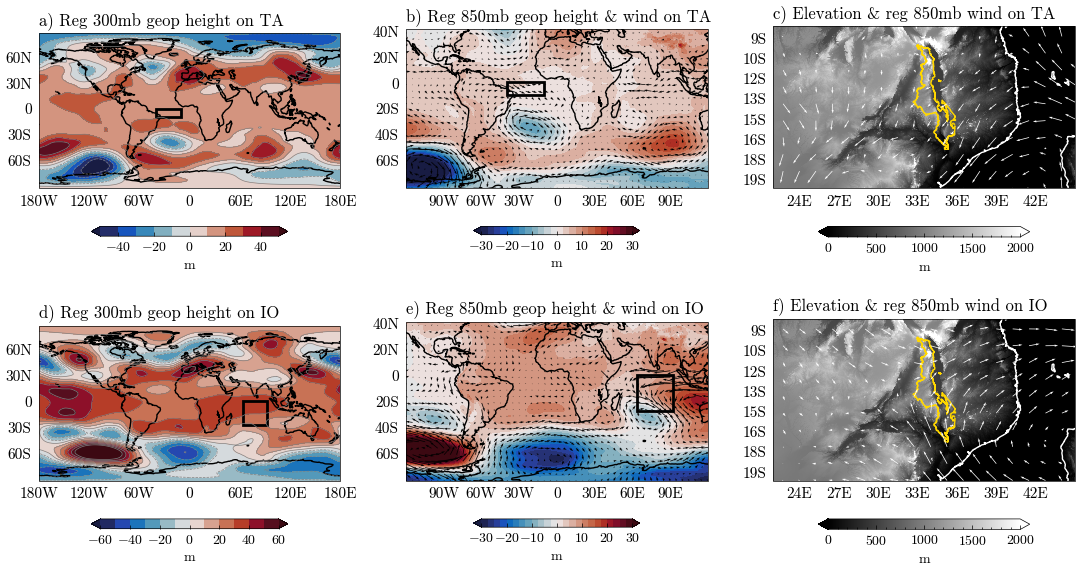

In [6]:
# extract lons/lats for plotting
lons, lats = np.meshgrid(u.longitude.values, u.latitude.values)

with plt.style.context('science'):
    # fig setup
    plt.style.use(['no-latex'])    
    fig = plt.figure(figsize=(11, 6))
    
    # Panel a - reg_geop_300_anom_tropatl
    ax1 = fig.add_subplot(2, 3, 1, projection=ccrs.PlateCarree())
    pltmin = -50
    pltmax = 50
    contourstep=10
    cf = ax1.contourf(reg_geop_300_anom_tropatl.longitude, reg_geop_300_anom_tropatl.latitude, reg_geop_300_anom_tropatl, 
                      levels=np.arange(pltmin, pltmax + contourstep, contourstep), vmin=pltmin, vmax=pltmax, extend="both",
                     cmap=cm.cm.balance, transform=ccrs.PlateCarree())
    ax1.contour(reg_geop_300_anom_tropatl.longitude, reg_geop_300_anom_tropatl.latitude, reg_geop_300_anom_tropatl,
                      levels=np.arange(pltmin, pltmax + contourstep, contourstep), vmin=pltmin, vmax=pltmax, 
                 colors='grey', transform=ccrs.PlateCarree(), linewidths=0.5)
    min_lon, max_lon = -40, -10
    min_lat, max_lat = -8, 2
    rect = Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                     linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
    ax1.add_patch(rect)
    plt.colorbar(cf, shrink=0.65, label="m", orientation="horizontal")
    ax1.coastlines()
    gl = ax1.gridlines(draw_labels=True, linewidth=0)
    gl.xformatter = FuncFormatter(format_lon)
    gl.yformatter = FuncFormatter(format_lat)
    gl.xlabel_style = {'size': 11}
    gl.ylabel_style = {'size': 11}
    gl.right_labels = []  # Remove right labels
    gl.top_labels = []    # Remove top labels
    plt.title('a) Reg 300mb geop height on TA', fontsize=12, weight='bold', loc='left')
    malawi_shape.plot(ax=ax1, edgecolor="black", linewidth=0.5, color="None")


    # Panel b - reg_geop_850_anom_tropatl
    ax2 = fig.add_subplot(2, 3, 2, projection=ccrs.PlateCarree())
    ax2.set_extent([-120, 120, -80, 43], crs=ccrs.PlateCarree())
    pltmin = -30
    pltmax = 30
    contourstep=2.5
    cf = ax2.contourf(reg_geop_850_anom_tropatl.longitude, reg_geop_850_anom_tropatl.latitude, reg_geop_850_anom_tropatl, 
                      levels=np.arange(pltmin, pltmax + contourstep, contourstep), vmin=pltmin, vmax=pltmax, extend="both",
                     cmap=cm.cm.balance, transform=ccrs.PlateCarree())
    min_lon, max_lon = -40, -10
    min_lat, max_lat = -8, 2
    rect = Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                     linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
    ax2.add_patch(rect)
    skip=20
    ax2.quiver(
        lons[::skip, ::skip],  
        lats[::skip, ::skip],   
        u_reg_tropatl[::skip, ::skip],  
        v_reg_tropatl[::skip, ::skip],  
        scale=45,  
        color="black", 
        linewidth=0.5,  
        transform=ccrs.PlateCarree(),
    )
    cb = plt.colorbar(cf, shrink=0.55, label="m", orientation="horizontal") 
    cb.set_ticks(ticks=np.arange(pltmin, pltmax+4*contourstep, 4*contourstep))
    ax2.coastlines()
    gl = ax2.gridlines(draw_labels=True, linewidth=0)
    gl.xformatter = FuncFormatter(format_lon)
    gl.yformatter = FuncFormatter(format_lat)
    gl.xlabel_style = {'size': 11}
    gl.ylabel_style = {'size': 11}
    gl.right_labels = []  # Remove right labels
    gl.top_labels = []    # Remove top labels
    plt.title('b) Reg 850mb geop height & wind on TA', fontsize=12, weight='bold', loc='left')
    malawi_shape.plot(ax=ax2, edgecolor="black", linewidth=0.5, color="None")


    # panel c - wind reg TA
    ax3 = fig.add_subplot(2, 3, 3, projection=ccrs.PlateCarree())
    ax3.set_extent([22, 45, -20, -8], crs=ccrs.PlateCarree())
    etopo01 = etopo01.sel(x=slice("20", "45"), y=slice("-25", "10")) 
    etopo01.plot(ax=ax3, cmap='gray', vmin=0, vmax=2000, transform=ccrs.PlateCarree(), cbar_kwargs={"shrink":0.7, "label": "m", "orientation": "horizontal"})
    malawi_shape.plot(ax=ax3, facecolor="none", edgecolor="gold", linewidth=1, transform=ccrs.PlateCarree())
    skip=5
    ax3.quiver(
        lons[::skip, ::skip],  
        lats[::skip, ::skip],   
        u_reg_tropatl[::skip, ::skip],  
        v_reg_tropatl[::skip, ::skip],  
        scale=8,  
        color="white", 
        linewidth=0.5,  
        transform=ccrs.PlateCarree(),
    )
    ax3.coastlines(color="white")
    gl = ax3.gridlines(draw_labels=True, linewidth=0)
    gl.xformatter = FuncFormatter(format_lon)
    gl.yformatter = FuncFormatter(format_lat)
    gl.xlabel_style = {'size': 11}
    gl.ylabel_style = {'size': 11}
    gl.right_labels = []  # Remove right labels
    gl.top_labels = []    # Remove top labels
    plt.title('c) Elevation & reg 850mb wind on TA', fontsize=12, weight='bold', loc='left')


    # Panel d - reg_geop_300_anom_io
    ax4 = fig.add_subplot(2, 3, 4, projection=ccrs.PlateCarree())
    pltmin = -60
    pltmax = 60
    contourstep=10
    cf = ax4.contourf(reg_geop_300_anom_io.longitude, reg_geop_300_anom_io.latitude, reg_geop_300_anom_io, 
                      levels=np.arange(pltmin, pltmax + contourstep, contourstep), vmin=pltmin, vmax=pltmax, extend="both",
                     cmap=cm.cm.balance, transform=ccrs.PlateCarree())
    ax4.contour(reg_geop_300_anom_io.longitude, reg_geop_300_anom_io.latitude, reg_geop_300_anom_io,
                      levels=np.arange(pltmin, pltmax + contourstep, contourstep), vmin=pltmin, vmax=pltmax, 
                 colors='grey', transform=ccrs.PlateCarree(), linewidths=0.5)
    
    min_lon, max_lon = 64, 92
    min_lat, max_lat = -26, 2
    rect = Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                     linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
    ax4.add_patch(rect)
    plt.colorbar(cf, shrink=0.65, label="m", orientation="horizontal")
    ax4.coastlines()
    gl = ax4.gridlines(draw_labels=True, linewidth=0)
    gl.xformatter = FuncFormatter(format_lon)
    gl.yformatter = FuncFormatter(format_lat)
    gl.xlabel_style = {'size': 11}
    gl.ylabel_style = {'size': 11}
    gl.right_labels = []  # Remove right labels
    gl.top_labels = []    # Remove top labels
    plt.title('d) Reg 300mb geop height on IO', fontsize=12, weight='bold', loc='left')
    malawi_shape.plot(ax=ax4, edgecolor="black", linewidth=0.5, color="None")


    # panel e - reg_geop_850_anom_io
    ax5 = fig.add_subplot(2, 3, 5, projection=ccrs.PlateCarree())
    ax5.set_extent([-120, 120, -80, 43], crs=ccrs.PlateCarree())
    pltmin = -30
    pltmax = 30
    contourstep=2.5
    cf = ax5.contourf(reg_geop_850_anom_io.longitude, reg_geop_850_anom_io.latitude, reg_geop_850_anom_io, 
                      levels=np.arange(pltmin, pltmax + contourstep, contourstep), vmin=pltmin, vmax=pltmax, extend="both",
                     cmap=cm.cm.balance, transform=ccrs.PlateCarree())
    skip=20
    ax5.quiver(
        lons[::skip, ::skip],  
        lats[::skip, ::skip],   
        u_reg_io[::skip, ::skip],  
        v_reg_io[::skip, ::skip],  
        scale=50,  
        color="black", 
        linewidth=0.5,  
        transform=ccrs.PlateCarree(),
    )
    min_lon, max_lon = 64, 92
    min_lat, max_lat = -26, 2
    rect = Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                     linewidth=2, edgecolor='black', facecolor='none', transform=ccrs.PlateCarree())
    ax5.add_patch(rect)
    cb = plt.colorbar(cf, shrink=0.55, label="m", orientation="horizontal") 
    cb.set_ticks(ticks=np.arange(pltmin, pltmax+4*contourstep, 4*contourstep))
    ax5.coastlines()
    gl = ax5.gridlines(draw_labels=True, linewidth=0)
    gl.xformatter = FuncFormatter(format_lon)
    gl.yformatter = FuncFormatter(format_lat)
    gl.xlabel_style = {'size': 11}
    gl.ylabel_style = {'size': 11}
    gl.right_labels = []  # Remove right labels
    gl.top_labels = []    # Remove top labels
    plt.title('e) Reg 850mb geop height & wind on IO', fontsize=12, weight='bold', loc='left')
    malawi_shape.plot(ax=ax5, edgecolor="black", linewidth=0.5, color="None")


    # panel f - wind reg IO
    ax6 = fig.add_subplot(2, 3, 6, projection=ccrs.PlateCarree())
    ax6.set_extent([22, 45, -20, -8], crs=ccrs.PlateCarree())
    etopo01.plot(ax=ax6, cmap='gray', vmin=0, vmax=2000, transform=ccrs.PlateCarree(), cbar_kwargs={"shrink":0.7, "label": "m", "orientation": "horizontal"})
    malawi_shape.plot(ax=ax6, facecolor="none", edgecolor="gold", linewidth=1, transform=ccrs.PlateCarree())
    skip=5
    ax6.quiver(
        lons[::skip, ::skip],  
        lats[::skip, ::skip],   
        u_reg_io[::skip, ::skip],  
        v_reg_io[::skip, ::skip],  
        scale=17,  
        color="white", 
        linewidth=0.5,  
        transform=ccrs.PlateCarree(),
    )
    ax6.coastlines(color="white")
    gl = ax6.gridlines(draw_labels=True, linewidth=0)
    gl.xformatter = FuncFormatter(format_lon)
    gl.yformatter = FuncFormatter(format_lat)
    gl.xlabel_style = {'size': 11}
    gl.ylabel_style = {'size': 11}
    gl.right_labels = []  # Remove right labels
    gl.top_labels = []    # Remove top labels
    plt.title('f) Elevation & reg 850mb wind on IO', fontsize=12, weight='bold', loc='left')

    plt.tight_layout()
    plt.savefig("figures/manuscript/Figure3.png", dpi=300, transparent=True, bbox_inches="tight")
    plt.show()

## Figure 4. Atmospheric response to SST regions (vimdf, precip, and soil moisture)

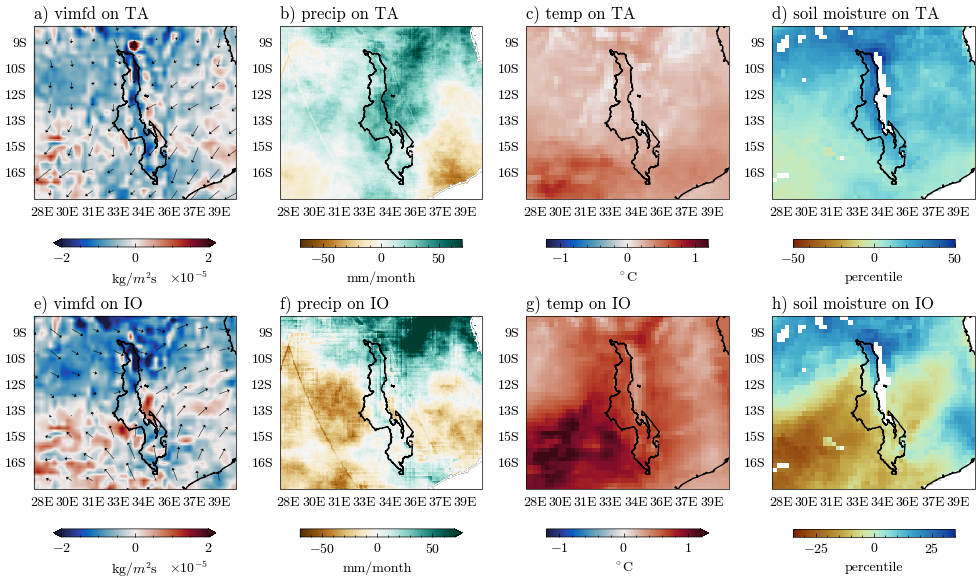

In [7]:
with plt.style.context('science'):
    # fig setup
    plt.style.use(['no-latex'])    
    fig = plt.figure(figsize=(10, 6))
    plt.subplots_adjust(wspace=0.5)
    
    # Panel a - reg_vimdf_TA_smoothed
    ax1 = fig.add_subplot(2, 4, 1, projection=ccrs.PlateCarree())
    ax1.set_extent([28, 40, -18, -8], crs=ccrs.PlateCarree())
    im = reg_vimdf_TA_smoothed.plot(cmap=cm.cm.balance, 
                               transform=ccrs.PlateCarree(), 
                               add_colorbar=False,vmin=-2e-5, vmax=2e-5,
                          )
    cbar = plt.colorbar(im, ax=ax1, shrink=0.8, extend="both", label=r"kg/$m^2$s", orientation="horizontal")
    
    cbar.formatter.set_powerlimits((0, 0))
    cbar.formatter.set_useMathText(True)
    
    malawi_shape.plot(ax=ax1, edgecolor='black', color="None")
    
    ax1.coastlines()
    gl = ax1.gridlines(draw_labels=True, linewidth=0)
    gl.xformatter = FuncFormatter(format_lon)
    gl.yformatter = FuncFormatter(format_lat)
    gl.right_labels = []  # Remove right labels
    gl.top_labels = []    # Remove top labels

    # wind reg for ref
    skip=5
    ax1.quiver(
        lons[::skip, ::skip],  
        lats[::skip, ::skip],   
        u_reg_tropatl[::skip, ::skip],  
        v_reg_tropatl[::skip, ::skip],  
        scale=4,
        headwidth=8,
        color="black", 
        transform=ccrs.PlateCarree(),
    )

    
    plt.title('a) vimfd on TA', fontsize=12, weight='bold', loc='left')

    # Panel b - precip_reg_masked_TA
    ax2 = fig.add_subplot(2, 4, 2, projection=ccrs.PlateCarree())
    ax2.coastlines()
    ax2.set_extent([28, 40, -18, -8], crs=ccrs.PlateCarree())
    malawi_shape.plot(ax=ax2, facecolor="none", edgecolor="black", linewidth=1, 
                      transform=ccrs.PlateCarree(),zorder=10)
    
    precip_reg_masked_TA.plot(cmap="BrBG", transform=ccrs.PlateCarree(), vmin=-70, vmax=70, 
                           cbar_kwargs={"shrink": 0.8,  "orientation": "horizontal", "label": "mm/month", "extend": "neither"})
    
    ax2.coastlines(color="white")
    gl = ax2.gridlines(draw_labels=True, linewidth=0)
    gl.xformatter = FuncFormatter(format_lon)
    gl.yformatter = FuncFormatter(format_lat)
    gl.right_labels = []  # Remove right labels
    gl.top_labels = []    # Remove top labels
    plt.title('b) precip on TA', fontsize=12, weight='bold', loc='left')

    
    # Panel c - temp_reg_tropatl_masked
    ax3 = fig.add_subplot(2, 4, 3, projection=ccrs.PlateCarree())
    ax3.set_extent([28, 40, -18, -8], crs=ccrs.PlateCarree())
    vmin = -1.2
    vmax = 1.2
    malawi_shape.plot(ax=ax3, facecolor="None", edgecolor="black", linewidth=1, transform=ccrs.PlateCarree(), zorder=10)
    temp_reg_tropatl_masked.plot(
        vmin=vmin, 
        vmax=vmax, 
        cmap=cm.cm.balance, 
        transform=ccrs.PlateCarree(),
        cbar_kwargs={
            "orientation": "horizontal",
            "shrink": 0.8,
            "label": "$^\circ$C"}
    )
    ax3.coastlines()
    gl = ax3.gridlines(draw_labels=True, linewidth=0)
    gl.xformatter = FuncFormatter(format_lon)
    gl.yformatter = FuncFormatter(format_lat)
    gl.right_labels = []  # Remove right labels
    gl.top_labels = []    # Remove top labels
    plt.title('c) temp on TA', fontsize=12, weight='bold', loc='left')


    # Panel d - soil_reg_tropatl_masked
    ax4 = fig.add_subplot(2, 4, 4, projection=ccrs.PlateCarree())
    ax4.set_extent([28, 40, -18, -8], crs=ccrs.PlateCarree())
    vmin = -50
    vmax = 50
    malawi_shape.plot(
        ax=ax4,
        facecolor="None",
        edgecolor="black", 
        linewidth=1,
        transform=ccrs.PlateCarree(),
        zorder=10
        )
    soil_reg_tropatl_masked.plot(
        vmin=vmin, 
        vmax=vmax,
        cmap=cmc.roma, 
        transform=ccrs.PlateCarree(),
        cbar_kwargs={
            "orientation": "horizontal",
            "shrink": 0.8,
            "label": "percentile"}
        )
    ax4.coastlines()
    gl = ax4.gridlines(draw_labels=True, linewidth=0)
    gl.xformatter = FuncFormatter(format_lon)
    gl.yformatter = FuncFormatter(format_lat)
    gl.right_labels = []  # Remove right labels
    gl.top_labels = []    # Remove top labels
    plt.title('d) soil moisture on TA', fontsize=12, weight='bold', loc='left')

    
    # Panel e - reg_vimdf_IO_smoothed
    ax5 = fig.add_subplot(2, 4, 5, projection=ccrs.PlateCarree())
    ax5.set_extent([28, 40, -18, -8], crs=ccrs.PlateCarree())
    im = reg_vimdf_IO_smoothed.plot(cmap=cm.cm.balance, 
                               transform=ccrs.PlateCarree(), 
                               add_colorbar=False,vmin=-2e-5, vmax=2e-5,
                          )
    cbar = plt.colorbar(im, ax=ax5, shrink=0.8, extend="both", label=r"kg/$m^2$s", orientation="horizontal")
    cbar.formatter.set_powerlimits((-5, -5))
    #cbar.formatter.set_useMathText(True)
    malawi_shape.plot(ax=ax5, color="None")
    ax5.coastlines()
    gl = ax5.gridlines(draw_labels=True, linewidth=0)
    gl.xformatter = FuncFormatter(format_lon)
    gl.yformatter = FuncFormatter(format_lat)
    gl.right_labels = []  # Remove right labels
    gl.top_labels = []    # Remove top labels

    # wind reg for ref
    skip=5
    ax5.quiver(
        lons[::skip, ::skip],  
        lats[::skip, ::skip],   
        u_reg_io[::skip, ::skip],  
        v_reg_io[::skip, ::skip],  
        scale=10,  
        headwidth=8,
        color="black", 
        transform=ccrs.PlateCarree(),
    )
    plt.title('e) vimfd on IO', fontsize=12, weight='bold', loc='left')

    
    # Panel f - precip_reg_masked_TA
    ax6 = fig.add_subplot(2, 4, 6, projection=ccrs.PlateCarree())
    ax6.coastlines()
    ax6.set_extent([28, 40, -18, -8], crs=ccrs.PlateCarree())
    malawi_shape.plot(ax=ax6, facecolor="none", edgecolor="black", linewidth=1, 
                      transform=ccrs.PlateCarree(),zorder=10)
    
    precip_reg_masked_IO.plot(cmap="BrBG", transform=ccrs.PlateCarree(), vmin=-70, vmax=70, 
                           cbar_kwargs={"shrink": 0.8, "orientation": "horizontal", "label": "mm/month", "extend": "max"})
    
    ax6.coastlines(color="white")
    gl = ax6.gridlines(draw_labels=True, linewidth=0)
    gl.xformatter = FuncFormatter(format_lon)
    gl.yformatter = FuncFormatter(format_lat)
    gl.right_labels = []  # Remove right labels
    gl.top_labels = []    # Remove top labels
    plt.title('f) precip on IO', fontsize=12, weight='bold', loc='left')


    # Panel g - temp_reg_io_masked
    ax7 = fig.add_subplot(2, 4, 7, projection=ccrs.PlateCarree())
    ax7.set_extent([28, 40, -18, -8], crs=ccrs.PlateCarree())
    malawi_shape.plot(ax=ax7, facecolor="None", edgecolor="black", linewidth=1, transform=ccrs.PlateCarree(), zorder=10)
    temp_reg_io_masked.plot(
        vmin=-1.2, 
        vmax=1.2, 
        cmap=cm.cm.balance, 
        transform=ccrs.PlateCarree(),
        cbar_kwargs={
            "orientation": "horizontal",
            "shrink": 0.8,
            "label": "$^\circ$C"}
        )
    ax7.coastlines()
    gl = ax7.gridlines(draw_labels=True, linewidth=0)
    gl.xformatter = FuncFormatter(format_lon)
    gl.yformatter = FuncFormatter(format_lat)
    gl.right_labels = []  # Remove right labels
    gl.top_labels = []    # Remove top labels
    plt.title('g) temp on IO', fontsize=12, weight='bold', loc='left')


    # Panel h - soil_reg_io_masked
    ax8 = fig.add_subplot(2, 4, 8, projection=ccrs.PlateCarree())
    ax8.set_extent([28, 40, -18, -8], crs=ccrs.PlateCarree())
    vmin = -35
    vmax = 35
    malawi_shape.plot(
        ax=ax8,
        facecolor="None",
        edgecolor="black", 
        linewidth=1,
        transform=ccrs.PlateCarree(),
        zorder=10
        )
    soil_reg_io_masked.plot(
        vmin=vmin, 
        vmax=vmax,
        cmap=cmc.roma, 
        transform=ccrs.PlateCarree(),
        cbar_kwargs={
            "orientation": "horizontal",
            "shrink": 0.8,
            "label": "percentile"}
        )
    ax8.coastlines()
    gl = ax8.gridlines(draw_labels=True, linewidth=0)
    gl.xformatter = FuncFormatter(format_lon)
    gl.yformatter = FuncFormatter(format_lat)
    gl.right_labels = []  # Remove right labels
    gl.top_labels = []    # Remove top labels
    plt.title('h) soil moisture on IO', fontsize=12, weight='bold', loc='left')


    
    plt.tight_layout()
    plt.savefig("figures/manuscript/Figure4.png", dpi=300, transparent=True, bbox_inches="tight")
    plt.show()

Some stats for the text 

In [8]:
malawi_shape_buffered = gpd.GeoDataFrame(geometry=malawi_shape.buffer(0.01)).to_crs("EPSG:4326") 
def get_reg_stats_mal(ds, varname, lon="longitude", lat="latitude"):  
    
    ds.rio.set_spatial_dims(x_dim=lon, y_dim=lat, inplace=True)
    ds.rio.write_crs("EPSG:4326", inplace=True)
    stat_malawi = ds.rio.clip(malawi_shape_buffered.geometry.apply(mapping), malawi_shape_buffered.crs, drop=True)
    print(f"Min {varname}: {stat_malawi.min().values} / SD SST")
    print(f"Max {varname}: {stat_malawi.max().values} / SD SST")
    print(f"Average {varname}: {stat_malawi.mean().values} / SD SST")

TA reg stats

In [9]:
get_reg_stats_mal(precip_reg_masked_TA, "precip")

Min precip: -1.9703676636794984 / SD SST
Max precip: 55.316646816055155 / SD SST
Average precip: 23.832949831452517 / SD SST


In [10]:
get_reg_stats_mal(reg_vimdf_TA_smoothed, "vimfd")

Min vimfd: -2.80440875861732e-05 / SD SST
Max vimfd: 9.116880110410402e-06 / SD SST
Average vimfd: -6.7429483553628185e-06 / SD SST


In [11]:
get_reg_stats_mal(temp_reg_tropatl_masked, "temp")

Min temp: 0.12286712974309921 / SD SST
Max temp: 0.386007696390152 / SD SST
Average temp: 0.23171715034070864 / SD SST


In [12]:
get_reg_stats_mal(soil_reg_tropatl_masked, "soilm")

Min soilm: 3.890188455581665 / SD SST
Max soilm: 46.94922637939453 / SD SST
Average soilm: 21.95801677290849 / SD SST


IO reg stats

In [13]:
get_reg_stats_mal(precip_reg_masked_IO, "precip")

Min precip: -38.61009901841888 / SD SST
Max precip: 73.69895309162797 / SD SST
Average precip: 7.683333470473804 / SD SST


In [14]:
get_reg_stats_mal(reg_vimdf_IO_smoothed, "vimfd")

Min vimfd: -3.950877369904158e-05 / SD SST
Max vimfd: 7.349521219389437e-06 / SD SST
Average vimfd: -6.437464089868843e-06 / SD SST


In [15]:
get_reg_stats_mal(temp_reg_io_masked, "temp")

Min temp: 0.3938010632991791 / SD SST
Max temp: 0.877567708492279 / SD SST
Average temp: 0.6588167559730914 / SD SST


In [16]:
get_reg_stats_mal(soil_reg_io_masked, "soilm")

Min soilm: -14.695618629455566 / SD SST
Max soilm: 27.391645431518555 / SD SST
Average soilm: -2.755065307021141 / SD SST


## Figure 5. Soil moisture vs. other predictors

In [17]:
# add district geometries to district correlation dfs
for var in ["soilm", "precip", "temp"]:
    dfname = f"malavg_{var}"
    merged = locals()[dfname].merge(dist_shape[['DISTRICT', 'geometry']], 
                            on='DISTRICT', 
                            how='left')
    locals()[dfname] = gpd.GeoDataFrame(merged, geometry='geometry', crs=dist_shape.crs)

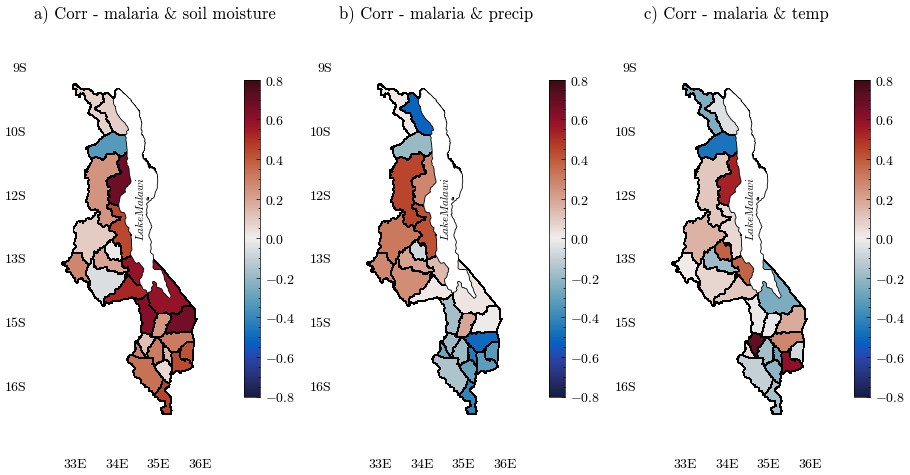

In [18]:
with plt.style.context('science'):
    # fig setup
    plt.style.use(['no-latex'])    
    fig = plt.figure(figsize=(12, 6))
    
    # Panel a - malavg_soilm
    ax1 = fig.add_subplot(1, 4, 1, projection=ccrs.PlateCarree())
    ax1.set_extent([32, 37, -18, -8], crs=ccrs.PlateCarree())
    # malavgscale = malavg.copy()
    # malavgscale["CASES"] = malavgscale["CASES"]*1e-4
    malavg_soilm.plot(ax=ax1, facecolor="None", edgecolor="black", linewidth=0.6, transform=ccrs.PlateCarree(), zorder=2)
    im0 = malavg_soilm.plot(column='corr_soilm', 
                      cmap=cm.cm.balance, 
                      ax=ax1, 
                      transform=ccrs.PlateCarree(), 
                      zorder=1,
                     vmin=-0.8,
                     vmax=0.8)
    # plt.sca(ax)
    plt.xlim(32, 37)
    plt.ylim(-18, -8)
    plt.gca().set_aspect('equal')
    gl = ax1.gridlines(draw_labels=True, linewidth=0)
    gl.xformatter = FuncFormatter(format_lon)
    gl.yformatter = FuncFormatter(format_lat)
    gl.right_labels = []
    gl.top_labels = []
    ax1.axis('off')
    fig.colorbar(im0.get_children()[1], ax=ax1, orientation='vertical', fraction=0.07, shrink=0.7, pad=0.01)
    lake_malawi.plot(ax=ax1, color="white", alpha=1, zorder=12, edgecolor="black", linewidth=0.6)
    ax1.annotate(text='$\it{Lake Malawi}$', xy=(34.53, -13), ha='center', zorder=13, color="black", fontsize=8, rotation=90)
    ax1.set_title("a) Corr - malaria & soil moisture", fontsize=12, weight='bold', loc='left')

    
    # panel b - malavg_precip
    ax2 = fig.add_subplot(1, 4, 2, projection=ccrs.PlateCarree())
    ax2.set_extent([32, 37, -18, -8], crs=ccrs.PlateCarree())
    # malavgscale = malavg.copy()
    # malavgscale["CASES"] = malavgscale["CASES"]*1e-4
    malavg_precip.plot(ax=ax2, facecolor="None", edgecolor="black", linewidth=0.6, transform=ccrs.PlateCarree(), zorder=2)
    im0 = malavg_precip.plot(column='corr_precip', 
                      cmap=cm.cm.balance, 
                      ax=ax2, 
                      transform=ccrs.PlateCarree(), 
                      zorder=1,
                     vmin=-0.8,
                     vmax=0.8)
    # plt.sca(ax)
    plt.xlim(32, 37)
    plt.ylim(-18, -8)
    plt.gca().set_aspect('equal')
    gl = ax2.gridlines(draw_labels=True, linewidth=0)
    gl.xformatter = FuncFormatter(format_lon)
    gl.yformatter = FuncFormatter(format_lat)
    gl.right_labels = []
    gl.top_labels = []
    ax2.axis('off')
    fig.colorbar(im0.get_children()[1], ax=ax2, orientation='vertical', fraction=0.07, shrink=0.7, pad=0.01)
    lake_malawi.plot(ax=ax2, color="white", alpha=1, zorder=12, edgecolor="black", linewidth=0.6)
    ax2.annotate(text='$\it{Lake Malawi}$', xy=(34.53, -13), ha='center', zorder=13, color="black", fontsize=8, rotation=90)
    ax2.set_title("b) Corr - malaria & precip", fontsize=12, weight='bold', loc='left')

    # panel c - malavg_temp
    ax3 = fig.add_subplot(1, 4, 3, projection=ccrs.PlateCarree())
    ax3.set_extent([32, 37, -18, -8], crs=ccrs.PlateCarree())
    # malavgscale = malavg.copy()
    # malavgscale["CASES"] = malavgscale["CASES"]*1e-4
    malavg_temp.plot(ax=ax3, facecolor="None", edgecolor="black", linewidth=0.6, transform=ccrs.PlateCarree(), zorder=2)
    im0 = malavg_temp.plot(column='corr_temp', 
                      cmap=cm.cm.balance, 
                      ax=ax3, 
                      transform=ccrs.PlateCarree(), 
                      zorder=1,
                     vmin=-0.8,
                     vmax=0.8)
    
    # plt.sca(ax)
    plt.xlim(32, 37)
    plt.ylim(-18, -8)
    plt.gca().set_aspect('equal')
    gl = ax3.gridlines(draw_labels=True, linewidth=0)
    gl.xformatter = FuncFormatter(format_lon)
    gl.yformatter = FuncFormatter(format_lat)
    gl.right_labels = []
    gl.top_labels = []
    ax3.axis('off')
    fig.colorbar(im0.get_children()[1], ax=ax3, orientation='vertical', fraction=0.07, shrink=0.7, pad=0.01)
    lake_malawi.plot(ax=ax3, color="white", alpha=1, zorder=12, edgecolor="black", linewidth=0.6)
    ax3.annotate(text='$\it{Lake Malawi}$', xy=(34.53, -13), ha='center', zorder=13, color="black", fontsize=8, rotation=90)
    ax3.set_title("c) Corr - malaria & temp", fontsize=12, weight='bold', loc='left')


    lake_malawi.plot(ax=ax4, color="white", alpha=1, zorder=12, edgecolor="black", linewidth=0.6)
    ax4.annotate(text='$\it{Lake Malawi}$', xy=(34.53, -13), ha='center', zorder=13, color="black", fontsize=8, rotation=90)
    ax4.set_title("d) Soil texture", fontsize=12, weight='bold', loc='left')

    plt.tight_layout()
    plt.savefig("figures/manuscript/Figure5.png", dpi=300, transparent=True, bbox_inches="tight")
    plt.show()

## Figure 6. Relationship between soil moisture and malaria

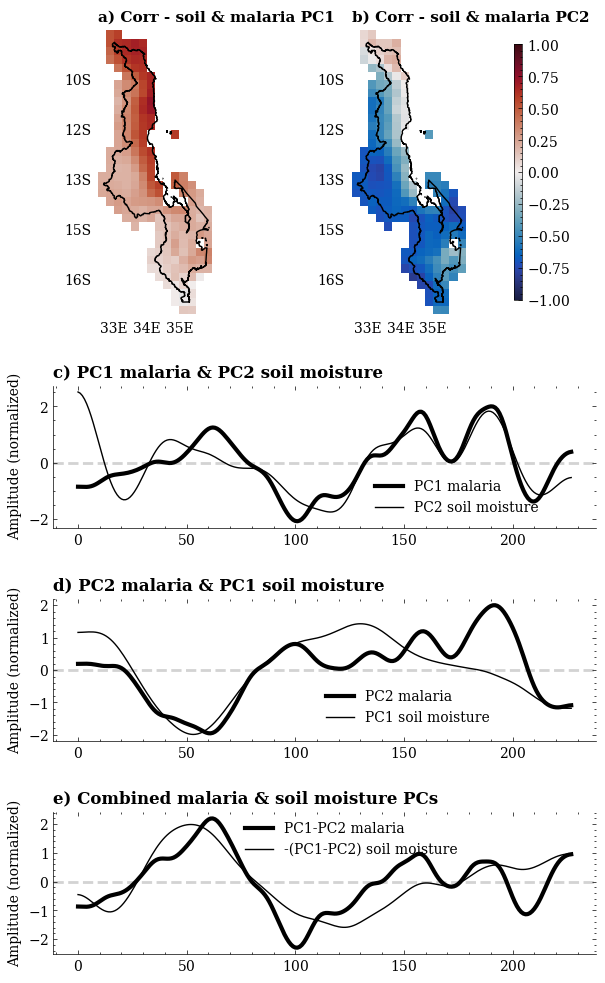

In [19]:
with plt.style.context('science'):
    plt.style.use(['no-latex'])
    fig = plt.figure(figsize=(7, 12))
    gs = fig.add_gridspec(4, 2, height_ratios=[1.5, 0.75, 0.75, 0.75],  hspace=0.4, wspace=0.6)

    # a) correlation_map_soilm_pc1
    ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
    malawi_extent = [32.5, 36, -17.5, -9]
    ax1.set_extent(malawi_extent, crs=ccrs.PlateCarree())
    im1 = correlation_map_soilm_pc1.plot(cmap=cm.cm.balance, vmin=-1, vmax=1, transform=ccrs.PlateCarree(), add_colorbar=False)
    malawi_shape.plot(ax=ax1, facecolor="none", edgecolor="black", linewidth=1, transform=ccrs.PlateCarree())
    ax1.coastlines()
    gl = ax1.gridlines(draw_labels=True, linewidth=0)
    gl.xformatter = FuncFormatter(format_lon)
    gl.yformatter = FuncFormatter(format_lat)
    gl.right_labels = []
    gl.top_labels = []
    ax1.axis('off')
    plt.title('a) Corr - soil & malaria PC1', fontsize=11, weight='bold', loc='left')

    # b) correlation_map_soilm_pc2
    ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
    malawi_extent = [32.5, 36, -17.5, -9]
    ax2.set_extent(malawi_extent, crs=ccrs.PlateCarree())
    im2 = correlation_map_soilm_pc2.plot(cmap=cm.cm.balance, vmin=-1, vmax=1, transform=ccrs.PlateCarree(), add_colorbar=False)
    malawi_shape.plot(ax=ax2, facecolor="none", edgecolor="black", linewidth=1, transform=ccrs.PlateCarree())
    ax2.coastlines()
    gl = ax2.gridlines(draw_labels=True, linewidth=0)
    gl.xformatter = FuncFormatter(format_lon)
    gl.yformatter = FuncFormatter(format_lat)
    gl.right_labels = []
   # gl.left_labels = []
    gl.top_labels = []
    ax2.axis('off')
    plt.title('b) Corr - soil & malaria PC2', fontsize=11, weight='bold', loc='left')
    
    cbar = plt.colorbar(im1, ax=[ax1, ax2], orientation='vertical', pad=0.09, shrink=0.9, aspect=35)

    # c) 
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(cases_pivot.index, zscore(sm_pc1_cases_24), label='PC1 malaria', color='black', linewidth=3, zorder=2)
    ax3.plot(cases_pivot.index, zscore(sm_soilm_pc2), color='black', linewidth=1, label='PC2 soil moisture')
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_linewidth(0.5)
    ax3.legend(bbox_to_anchor=(0.57, 0., 0.5, 0.5))
    plt.title('c) PC1 malaria & PC2 soil moisture', fontsize=12, weight='bold', loc='left')
    plt.axhline(0, color='lightgrey', linestyle="--", linewidth=2, zorder=1)
    plt.ylabel("Amplitude (normalized)")
    
    # d) 
    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(cases_pivot.index, zscore(sm_pc2_cases_24), label='PC2 malaria', color='black', linewidth=3, zorder=2)
    ax4.plot(cases_pivot.index, zscore(sm_soilm_pc1), color='black', linewidth=1, label='PC1 soil moisture')
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_linewidth(0.5)
    ax4.legend(bbox_to_anchor=(0.48, -0.05, 0.5, 0.5))
    plt.title('d) PC2 malaria & PC1 soil moisture', fontsize=12, weight='bold', loc='left')
    plt.axhline(0, color='lightgrey', linestyle="--", linewidth=2, zorder=1)
    plt.ylabel("Amplitude (normalized)")


    # e) pc1 - pc2
    ax5 = fig.add_subplot(gs[3, :])
    sumpcs_mal = zscore(sm_pc1_cases_24 - sm_pc2_cases_24)
    sumpcs_soil = -zscore(sm_soilm_pc1 - sm_soilm_pc2)
    ax5.plot(cases_pivot.index, sumpcs_mal, label='PC1-PC2 malaria', color='black', linewidth=3, zorder=2)
    ax5.plot(cases_pivot.index, sumpcs_soil, color='black', linewidth=1, label='-(PC1-PC2) soil moisture')
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_linewidth(0.5)
    ax5.legend(bbox_to_anchor=(0.3, 0.52, 0.5, 0.5))
    plt.title('e) Combined malaria & soil moisture PCs', fontsize=12, weight='bold', loc='left')
    plt.axhline(0, color='lightgrey', linestyle="--", linewidth=2, zorder=1)
    plt.ylabel("Amplitude (normalized)")
    plt.tight_layout()
    plt.savefig("figures/manuscript/Figure6.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

## Figure 7.  See analysis_cmip6.ipynb

## Supplementary/Extended data

##### 2m temperature when IO anomalies are positive, zonal mean subtracted (temperature advection evidence) 

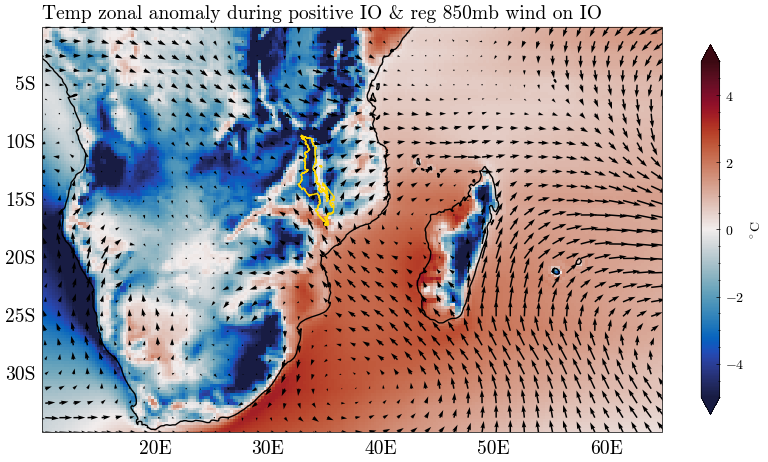

In [20]:
# temperature advection here probably for the warming during SST anoms
vmin=-5
vmax=5

with plt.style.context('science'):
    plt.style.use(['no-latex'])
    # TA Afr
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))
    ax.set_extent([10, 65, -35, 0], crs=ccrs.PlateCarree())
    malawi_shape.plot(ax=ax, facecolor="None", edgecolor="gold", linewidth=1, transform=ccrs.PlateCarree(), zorder=10)
    contourstep=1

    # temp while positive IO, zonal anom
    temp_IO_pos_zonal_anom.drop_vars(["number", "step", "surface"]).plot(vmin=vmin, vmax=vmax,
                     cmap=cm.cm.balance, transform=ccrs.PlateCarree(), cbar_kwargs={"shrink": 0.8, "label": "$^\circ$C"})

    # plot wind quivers from reg 850mb on TA
    skip=5
    ax.quiver(
        lons[::skip, ::skip],  
        lats[::skip, ::skip],   
        u_reg_io[::skip, ::skip],  
        v_reg_io[::skip, ::skip],  
        scale=47,  
        color="black", 
        linewidth=0.5,  
        transform=ccrs.PlateCarree(),
    )

    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linewidth=0)
    gl.xformatter = FuncFormatter(format_lon)
    gl.yformatter = FuncFormatter(format_lat)
    gl.right_labels = []  # Remove right labels
    gl.top_labels = []    # Remove top labels
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}
    plt.title('Temp zonal anomaly during positive IO & reg 850mb wind on IO', fontsize=14, weight='bold', loc='left')
    plt.savefig("figures/supp/supp_tadv.png", dpi=300, transparent=True, bbox_inches="tight")
    plt.show()

### Soil Texture

In [21]:
# clip dataset around malawi boundaries
gldas_resampled.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
gldas_resampled.rio.write_crs("EPSG:4326", inplace=True)

gldas_mal = gldas_resampled.rio.clip(
    malawi_shape_buffered.geometry.apply(mapping), 
    malawi_shape_buffered.crs, 
    drop=True
)

# colors for map based on crameri batlow
colors_mapped_soiltex = {3: "#fdb9c2", 
                 6: "#f6a077",
                 7: "#c49138",
                 8: "#818232",
                 9: "#48714f",
                 10: "#1e5c62",
                 12: "#0f3c5f"
                }
# data structures for plot
unique_soil_types = np.unique(gldas_mal)
# soil labels from GLDAS
soil_labels = {
    1: "Sand", 2: "Loamy Sand", 3: "Sandy Loam", 4: "Silt Loam", 5: "Silt", 6: "Loam",
    7: "Sandy Clay Loam", 8: "Silty Clay Loam", 9: "Clay Loam", 10: "Sandy Clay",
    11: "Silty Clay", 12: "Clay", 13: "Organic Materials", 14: "Water", 15: "Bedrock", 16: "Other"
}
present_soil_types = sorted([int(v) for v in np.unique(gldas_mal.values) if not np.isnan(v)])
values_soiltex = sorted(colors_mapped_soiltex.keys())
colors_soiltex = [colors_mapped_soiltex[v] for v in values_soiltex]
cmap_soiltex = ListedColormap(colors_soiltex)
boundaries_soiltex = [v - 0.5 for v in values_soiltex] + [values_soiltex[-1] + 0.5]
norm_soiltex = BoundaryNorm(boundaries_soiltex, len(colors_soiltex))

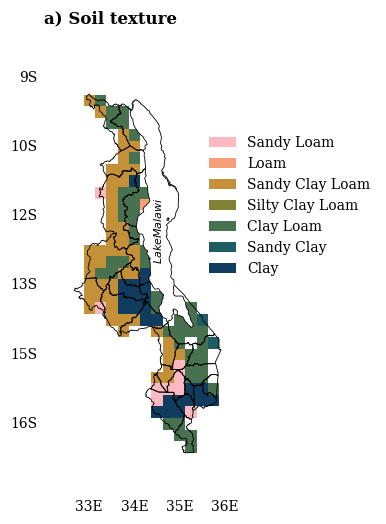

In [22]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([32, 37, -18, -8], crs=ccrs.PlateCarree())
im = ax.pcolormesh(
    gldas_mal.lon, 
    gldas_mal.lat, 
    gldas_mal.values, 
    cmap=cmap_soiltex, 
    norm=norm_soiltex, 
    transform=ccrs.PlateCarree()
)
dist_shape.plot(ax=ax, facecolor="None", edgecolor="black", linewidth=0.6, transform=ccrs.PlateCarree(), zorder=10)

cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.07, shrink=0.7, pad=0.01)
cbar.ax.set_visible(False)

patches = [mpatches.Rectangle((0,0),1,1, facecolor=colors_mapped_soiltex[v]) for v in values_soiltex]  
labels = [soil_labels[v] for v in values_soiltex]
plt.legend(patches, labels, bbox_to_anchor=(1.5,0.8), loc='upper right', ncol=1, frameon=False)

ax.set_frame_on(False)
plt.xlim(32, 37)
plt.ylim(-18, -8)
plt.gca().set_aspect('equal')
gl = ax.gridlines(draw_labels=True, linewidth=0)
gl.xformatter = FuncFormatter(format_lon)
gl.yformatter = FuncFormatter(format_lat)
gl.right_labels = []
gl.top_labels = []
ax.axis('off')

lake_malawi.plot(ax=ax, color="white", alpha=1, zorder=12, edgecolor="black", linewidth=0.6)
ax.annotate(text='$\it{Lake Malawi}$', xy=(34.53, -13), ha='center', zorder=13, color="black", fontsize=8, rotation=90)

plt.title('a) Soil texture', fontsize=12, weight='bold', loc='left')
plt.show()
plt.savefig("figures/supp/supp_soiltex.png", dpi=300, transparent=True, bbox_inches="tight")